<a href="https://colab.research.google.com/github/oakeshott/22SS-CSPTP-based-ILP/blob/master/jupyter/2022SummerSeminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5G通信基盤を支えるネットワーク仮想化技術によるネットワークの最適設計

## 概要

モバイルネットワークやインターネットなどの通信サービスは社会基盤となっており，私達は多種多様なサービスを享受できます．一方で，ネットワークに接続するデバイス数の増加や多様化するネットワークサービスに伴い，ネットワークは複雑化し，導入・運用コストが増大することが懸念されています．このような課題に対処するために，ネットワーク機能仮想化 (Network functions virtualization: NFV) 技術が大きく注目されています．NFVでは，専用機器で実現していたネットワーク機能を汎用機器上で仮想ネットワーク機能として実現することで，導入・運用コストを削減するとともに，ユーザの多様な要求に対してネットワークサービスを迅速かつ柔軟に展開可能なネットワークの設計を可能にします．任意のネットワークサービスは複数のネットワーク機能を連結したサービスチェインとして構成できます．本テーマでは，PythonやPulpなどを用いて，所望のユーザ要求に対するサービスチェインを実現する最適なサービスパスの設計を体験してもらいます．

## 目的

1. NFVネットワークにおけるサービスチェイニング問題の基本的性質を理解する
2. サービスチェイニング問題を解く手法の一つである整数線形計画問題を理解する
  - 整数線形計画問題は多くの問題で利用される
3. サービスチェイニング問題とShortest path tour problemの類似性を理解し，Shortest path tour problemを活用したサービスチェイニング手法を理解する

## 諸注意
自身のドライブ上でプログラムを実行してください．

## 環境設定

```
$ pip install pulp networkx matplotlib pandas
```

- Pulpの利用方法: https://coin-or.github.io/pulp/
- Networkxの利用方法: https://networkx.org/documentation/stable/

In [9]:
!pip install pulp networkx matplotlib pandas > /dev/null 2>&1

In [7]:
!rm -rf /content/22SS-CSPTP-based-ILP/
!git clone https://github.com/oakeshott/22SS-CSPTP-based-ILP > /dev/null 2>&1

In [10]:
import pulp
import networkx as nx
import os
import matplotlib.pyplot as plt
import json
import time
import pandas as pd

# PulpとNetworkxの利用方法の理解
 
## 例: 最短経路問題の定式化
 
- 入力: 
  * 有向グラフ$G=(\mathcal{V}, \mathcal{E})$, 始点$s$，終点$d$  
  * 各辺$(i,j) \in \mathcal{E}$の距離 $d_{i,j}$
  * 決定変数 $x_{i,j}$ $((i,j)\in\mathcal{E})$  
    * $x_{i,j}=1$の場合，リンク$(i,j)$を利用する
    * $x_{i,j}=0$の場合，リンク$(i,j)$を利用しない
  * $i == s$の場合，iは始点(供給点)なので供給量を1とする  
  * $i == d$の場合，iは終点(需要点)なので供給量を-1とする  
  * その他の場合，iは通過点なので需要と供給が釣り合うので供給量を0とする
  * $\mathcal{V}_i$: ノード$i$の隣接ノード集合
- 出力: 最短経路長
 
- 目的関数: 経路長を最小化
$$
\min \sum_{(i,j) \in \mathcal{E}} d_{i,j}x_{i,j}
$$
- 制約式
$$
\begin{align}
\mathrm{s.t.} &\quad x_{i,j} = \{0, 1\} \quad (i,j) \in \mathcal{E}\\
&\quad\sum_{j \in \mathcal{V_i}} x_{i,j} - \sum_{j \in \mathcal{V_i}} x_{j,i} = \begin{cases}
1 \quad &\textrm{if $i == s$,}\\
-1 \quad &\textrm{if $i == d$,}\\
0 \quad &\textrm{otherwise.}\\
\end{cases} i \in \mathcal{V}
\end{align}
$$

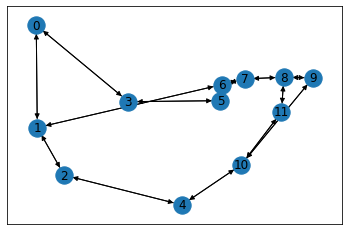

In [11]:
path = "/content/22SS-CSPTP-based-ILP/dataset/nsfnetbw"
filename = os.path.join(path, "network.gml")
G = nx.read_gml(filename, label="id")
pos = {n: (G.nodes()[n]["lng"], G.nodes()[n]["lat"]) for n in G.nodes()}
nx.draw_networkx(G, pos=pos)

In [12]:
print("Data fowarding delay", nx.get_node_attributes(G, "delay"))
print("Propagation delay", nx.get_edge_attributes(G, "delay"))
print("Processing capacity", nx.get_node_attributes(G, "capacity"))
print("Bandwidth", nx.get_edge_attributes(G, "bandwidth"))

Data fowarding delay {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1}
Propagation delay {(0, 1): 10.0, (0, 3): 10.0, (1, 0): 10.0, (1, 2): 10.0, (1, 6): 10.0, (2, 1): 10.0, (2, 4): 10.0, (3, 0): 10.0, (3, 5): 10.0, (4, 2): 10.0, (4, 10): 10.0, (5, 3): 10.0, (5, 6): 10.0, (6, 1): 10.0, (6, 5): 10.0, (6, 7): 10.0, (7, 8): 10.0, (7, 6): 10.0, (8, 9): 10.0, (8, 11): 10.0, (8, 7): 10.0, (9, 8): 10.0, (9, 10): 10.0, (10, 9): 10.0, (10, 11): 10.0, (10, 4): 10.0, (11, 8): 10.0, (11, 10): 10.0}
Processing capacity {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Bandwidth {(0, 1): 1000.0, (0, 3): 1000.0, (1, 0): 1000.0, (1, 2): 1000.0, (1, 6): 1000.0, (2, 1): 1000.0, (2, 4): 1000.0, (3, 0): 1000.0, (3, 5): 1000.0, (4, 2): 1000.0, (4, 10): 1000.0, (5, 3): 1000.0, (5, 6): 1000.0, (6, 1): 1000.0, (6, 5): 1000.0, (6, 7): 1000.0, (7, 8): 1000.0, (7, 6): 1000.0, (8, 9): 1000.0, (8, 11): 1000.0, (8, 7):

In [13]:
# define source and destination
source = 0
destination = 11
# define shortst path problem
problem = pulp.LpProblem("Shortest path problem", pulp.LpMinimize)

# define binary decision variables
x = {}
for i, j in G.edges():
  x[i,j] = pulp.LpVariable(f"x_{i},{j}", 0, 1, pulp.LpBinary)

# define objective function
problem += pulp.lpSum(G[i][j]["delay"] * x[i,j] for i, j in G.edges())

# define constraints
for i in G.nodes():
  if i == source:
    problem += pulp.lpSum(x[i,j] for j in G.neighbors(i)) - pulp.lpSum(x[j,i] for j in G.neighbors(i)) == 1, f"flow_constraint_node_{i}"
  elif i == destination:
    problem += pulp.lpSum(x[i,j] for j in G.neighbors(i)) - pulp.lpSum(x[j,i] for j in G.neighbors(i)) == -1, f"flow_constraint_node_{i}"
  else:
    problem += pulp.lpSum(x[i,j] for j in G.neighbors(i)) - pulp.lpSum(x[j,i] for j in G.neighbors(i)) == 0, f"flow_constraint_node_{i}"
print(problem)

Shortest_path_problem:
MINIMIZE
10.0*x_0,1 + 10.0*x_0,3 + 10.0*x_1,0 + 10.0*x_1,2 + 10.0*x_1,6 + 10.0*x_10,11 + 10.0*x_10,4 + 10.0*x_10,9 + 10.0*x_11,10 + 10.0*x_11,8 + 10.0*x_2,1 + 10.0*x_2,4 + 10.0*x_3,0 + 10.0*x_3,5 + 10.0*x_4,10 + 10.0*x_4,2 + 10.0*x_5,3 + 10.0*x_5,6 + 10.0*x_6,1 + 10.0*x_6,5 + 10.0*x_6,7 + 10.0*x_7,6 + 10.0*x_7,8 + 10.0*x_8,11 + 10.0*x_8,7 + 10.0*x_8,9 + 10.0*x_9,10 + 10.0*x_9,8 + 0.0
SUBJECT TO
flow_constraint_node_0: x_0,1 + x_0,3 - x_1,0 - x_3,0 = 1

flow_constraint_node_1: - x_0,1 + x_1,0 + x_1,2 + x_1,6 - x_2,1 - x_6,1 = 0

flow_constraint_node_2: - x_1,2 + x_2,1 + x_2,4 - x_4,2 = 0

flow_constraint_node_3: - x_0,3 + x_3,0 + x_3,5 - x_5,3 = 0

flow_constraint_node_4: - x_10,4 - x_2,4 + x_4,10 + x_4,2 = 0

flow_constraint_node_5: - x_3,5 + x_5,3 + x_5,6 - x_6,5 = 0

flow_constraint_node_6: - x_1,6 - x_5,6 + x_6,1 + x_6,5 + x_6,7 - x_7,6 = 0

flow_constraint_node_7: - x_6,7 + x_7,6 + x_7,8 - x_8,7 = 0

flow_constraint_node_8: - x_11,8 - x_7,8 + x_8,11 + x_8,7 +

/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [14]:
status = problem.solve()
print(f"Status: {pulp.LpStatus[status]}, Objective value: {pulp.value(problem.objective)}")
for i, j in G.edges():
  value = pulp.value(x[i,j])
  if value == 1:
    print(f"{i}\t{j}\t{value}")

Status: Optimal, Objective value: 50.0
0	1	1.0
1	6	1.0
6	7	1.0
7	8	1.0
8	11	1.0


In [15]:
shortest_path_length = nx.shortest_path_length(G, source, destination, weight="delay")
print(f"Shortest path length: {shortest_path_length}")

Shortest path length: 50.0


# 5Gネットワークの基盤を支えるネットワーク機能仮想化
## ネットワーク機能仮想化
- ネットワーク機能を専用機器から分離し，汎用機器上で仮想ネットワーク機能(Virtual network function: VNF)として実行
  * ネットワーク機能: 例えば，NATやFirewall(FW)など
- 多様なユーザの要求に対して，迅速かつ柔軟なネットワークサービスを展開可能
  * ネットワークサービス: 例えば，Video streamingやWeb serviceなど
- ネットワークサービスは複数のVNFからなる列(**サービスチェイン**)として構成できる
  * Video streamingの場合: NAT→FW→TM→VOC→IDPS というサービスチェインとして表現可能（**VNFの実行順序を保証**することが重要）
    * NAT: Network Address Translator
    * FW: Firewall
    * TM: Traffic Monitoring
    * VOC: Video Optimization Controller
    * IDPS: Intrusion Detection Prevention System
- 柔軟なネットワークサービスの展開により，導入・管理コストを削減可能

<figure>
<img src="https://raw.githubusercontent.com/oakeshott/21SS_CSPTP-baesed_ILP/master/fig/PNF_vs_VNF.png" width=80%></img>
</figure>

## サービスチェイニング問題
- ネットワークの資源制約の下で，所望の中間ノード上にあるVNFを実行しながら始点から終点までの**サービスパス**を構築する問題
- NP困難であることが知られている

## Shortest path tour problem (SPTP)
- 素なノード集合$\mathcal{T}_1, \ldots, \mathcal{T}_K$ ($\mathcal{T}_1, \cap \ldots \cap \mathcal{T}_K = \emptyset$)に含まれるノードを所望の順序で経由しながら，始点から終点までの最短路を計算する問題
- サービスチェイニングとの類似性が指摘されている

## システムモデル
### サービスチェイン要求
サービスチェイン要求はサービス要件$r_c$を持つ．NFVオーケストレータはサービス要件が満たされるようにサービスパスを確立しなければならない．
- サービス要件$r_c=(o_c, d_c, \mathrm{R}_c, b_c, p_c^{\mathrm{node}}, \{p_{c,f_{c,k}}\}_{k=1,\ldots,K_c})$
  * $o_c$: 始点ノード
  * $d_c$: 終点ノード
  * $\mathrm{R}_c$: $K_c$個のVNFの列 $\mathrm{R}_c = (f_{c,1},\ldots,f_{c,K_c+1})$
  * $b_c$: サービスチェイン要求$c$が要求する固定ビットレート帯域
  * $p_c^{\mathrm{node}}$: パケット転送に必要な処理容量
  * $p_{c,f_{c,k}}$: $k$番目のネットワーク機能$f_{c,k}$の実行に必要な処理容量
  * $\mathcal{K}_c = \{1, \ldots, K_c\}$
  * $\mathcal{K}_c^+ = \{1, \ldots, K_c+1\}$

<figure>
<img src="https://raw.githubusercontent.com/oakeshott/21SS_CSPTP-baesed_ILP/master/fig/service_chain_requirements.png" width=50%></img>
  <figcaption>サービスチェイン要求の例</figcaption>
</figure>

### 物理ネットワーク
物理ネットワークを有向グラフ$G=(\mathcal{V},\mathcal{E})$とする．
- $\mathcal{V}$: 物理ノードの集合
- $\mathcal{E}$: 物理リンクの集合

サービスチェイン要求を処理する際に，ネットワークの利用状況から各物理ノード$i \in \mathcal{V}$の残余処理容量$P_i$と各物理リンク$(i,j) \in \mathcal{E}$の残余帯域$B_{i,j}$が決まる．

NFVネットワークは$F$個の異なるネットワーク機能$F=\{f_1,\ldots,f_F\}$を提供できる．
<figure>
<img src="https://raw.githubusercontent.com/oakeshott/21SS_CSPTP-baesed_ILP/master/fig/physical_network.png" width=50%></img>
  <figcaption>物理ネットワークの例</figcaption>
</figure>

### 拡張ネットワーク
SPTPを実現するために物理ネットワークに架空ノード$\hat{\mathcal{V}}$と仮想リンク$\hat{\mathcal{E}}^\mathrm{in} \cup \hat{\mathcal{E}}^\mathrm{out}$を導入した拡張ネットワーク$G^+=(\mathcal{V}^+, \mathcal{E}^+)$を定義する．
- $\mathcal{V}^+=\mathcal{V} \cup \hat{\mathcal{V}}$
- $\mathcal{E}^+=\mathcal{E} \cup \hat{\mathcal{E}}^\mathrm{in} \cup \hat{\mathcal{E}}^\mathrm{out}$
- 架空ノード$\hat{v}_{f_{c,k}} \in \hat{\mathcal{V}}$は$k$番目のネットワーク機能$f_{c,k}$に対応
- 架空ノード$\hat{v}_{f_{c,k}} \in \hat{\mathcal{V}}$は$f_{c,k}$を搭載した物理ノードと仮想リンクにより接続
- **仮想リンク$(v, \hat{v}_{f_{c,k}})$の利用はネットワーク機能$f_{c,k}$の実行に対応**
- 仮想リンク$\hat{\mathcal{E}}^\mathrm{in}$は架空ノード$\hat{v}_f$に流入するリンクを表す
- 仮想リンク$\hat{\mathcal{E}}^\mathrm{out}$は架空ノード$\hat{v}_f$に流出するリンクを表す
- $\mathcal{V}^+_i$: ノード$i \in \mathcal{V}^+$の隣接ノード集合

<figure>
<img src="https://raw.githubusercontent.com/oakeshott/21SS_CSPTP-baesed_ILP/master/fig/augmented_network.png" width=50%></img>
  <figcaption>拡張ネットワークの例</figcaption>
</figure>

### サービスパス

ネットワークサービスを実現するために必要な資源を確保するために，サービスパスを構築する．
始点ノード$o_c$，終点ノード$d_c$，$\mathcal{R}_c=(f_{c,1},\ldots,f_{c,K_c})$のサービスチェイン要件を満たすサービスパス$\mathcal{S}_c$は$K_c+1$個のサブパスからなる列として構成できる（$\mathcal{S}_c=(\mathcal{S}_{c,1},\ldots,\mathcal{S}_{c,K_c+1})$）．  
各$k\in\mathcal{K}_c^+$番目のサブパスの始点ノード$a_k$，終点ノード$b_k$は次式で定義できる．

$$
(a_{k},b_{k}) =
\begin{cases}
  (o_c, \hat{v}_{f_{c,1}}), & k = 1\\
  (\hat{v}_{f_{c,k-1}}, \hat{v}_{f_{c,k}}),& k = 2,\ldots,K_c\\
  (\hat{v}_{f_{c,K_c}}, d_c), & k = K_c+1
\end{cases}
$$
<figure>
<img src="https://raw.githubusercontent.com/oakeshott/21SS_CSPTP-baesed_ILP/master/fig/service_path.png" width=50%></img>
  <figcaption>サービスパスの一例</figcaption>
</figure>

サービスパスの総遅延は以下の和として定義される．
* $d_{i,j}^{\mathrm{link}}$: 物理リンク$(i,j)$の伝送遅延
* $d_v^{\mathrm{node}}$: 物理ノード$v\in\mathcal{V}$がデータ転送に要する処理遅延
* $d_{\hat{v}_f,v}^{\mathrm{func}}$:物理ノード$v\in\mathcal{V}$が$f$を実行するために要する処理遅延

サービスパスは以下の特徴を持つため，最適なサービスチェイニングは困難な問題となる．
- サービスパスはループを含む
- サービスパス内の各サブパスはループを含まない
- 各ノード・リンクには容量制約が存在する


## SPTPに基づくサービスチェイニングの定式化
- 入力: 
  - 有向グラフ $G^+=(\mathcal{V}^+, \mathcal{E}^+)$
  - サービスチェイン要求$c$のサービス要件$r_c=(o_c, d_c, \mathrm{R}_c, b_c, p_c^{\mathrm{node}}, \{p_{c,f_{c,k}}\}_{k=1,\ldots,K_c})$
- 出力: サービスパス $\mathcal{S}_c$
- 目的関数: サービスパスの遅延の最小化
$$
  \min \quad \sum_{(i,j) \in \mathcal{E}^{+}} d_{i,j} \sum_{k \in \mathcal{K}_c^{+}} x_{i,j}^{k}
$$

$d_{i,j}$は次式で与えられる．
$$
d_{i,j} =     
\begin{cases}
  d_i^{\mathrm{node}} + d_{i,j}^{\mathrm{link}}, & \textrm{$(i, j) \in \mathcal{E}$の場合}
\\
  d_{i,j}^{\mathrm{func}}, & \textrm{$(i, j) \in \hat{\mathcal{E}}^{\mathrm{out}}$の場合}
\\
  0, & \textrm{それ以外}
\end{cases}
$$

$(i,j) \in \mathcal{E}$の場合，物理ノード$i$のデータ転送に要する処理遅延と物理リンク$(i,j)$の伝送遅延を考慮する．  
$(i,j) \in \hat{\mathcal{E}}^{\mathrm{out}}$の場合，物理ノードが機能$f$を実行するのに要する処理遅延のみを考慮する．  

- 制約式
$$
\begin{align}
\mathrm{s.t.} &\quad x_{i,j}^{k} = \{0,1\}, \quad (i,j) \in \mathcal{E}^+, k \in \mathcal{K}_c^+, &(1)\\
&\sum_{j \in \mathrm{V}_i^+} x_{i,j}^{k} - \sum_{j \in \mathrm{V}_i^+} x_{j,i}^{k} =
\begin{cases}
    1 & \textrm{if $i = a_{k}$,}\\
    -1 & \textrm{if $i = b_{k}$,}\\
    0 & \textrm{otherwise,}\\
\end{cases} i \in \mathcal{V}^+, k \in \mathcal{K}_c^+&(2)\\
&x_{i,\hat{v}_{f_{c,k}}}^{k} = x_{\hat{v}_{f_{c,k}},i}^{k+1} , \quad (i,\hat{v}_{f_{c,k}}) \in \hat{\mathcal{E}}^\mathrm{in}, (\hat{v}_{f_{c,k}},i) \in \hat{\mathcal{E}}^\mathrm{out}, k \in \mathcal{K}_c&(3)\\
&x_{i,\hat{v}_{f_{c,m}}}^{k} = 0, \quad (i,\hat{v}_{f_{c,m}}) \in \hat{\mathcal{E}}^\mathrm{in}, k \in \mathcal{K}_c^{+}, m \neq k&(4)\\
&b_c \sum_{k \in \mathcal{K}_c^{+}} x_{i,j}^{k} \leq B_{i,j}, \quad (i,j) \in \mathcal{E}&(5)\\
&p_c^\mathrm{node} \sum_{(v,j) \in \mathcal{E}} \sum_{k \in \mathcal{K}_c^{+}} x_{v,j}^{k} + \sum_{(\hat{v}_f,v) \in \hat{\mathcal{E}}^\mathrm{out}}p_{c,f}^\mathrm{func} \sum_{k \in \mathcal{K}_c^{+}} x_{\hat{v}_f,v}^{k} \leq P_v, \quad v \in \mathcal{V}.&(6)
\end{align}
$$

SPTPに関連する制約は(1)-(4)に該当する．
(1)は決定変数を表す．$x_{i,j}^{k}=1$の場合，$k$番目のサブパスにおいてリンク$(i,j)$を利用することを表し，$x_{i,j}^{k}=0$の場合，利用しないことを表す．
(2)はサービスパスに対するフロー量保存則を表す．(最短経路問題におけるフロー量の制約式と同じ)
(3)は$k$番目と$k+1$番目のサブパスの接続性を保証する．
(4)は$k$番目のサブパスにおいて，架空ノード$\hat{v}_{f_{c,m}}$の経由を禁止している．$(m \neq k)$
(5),(6)はそれぞれリンクとノードの容量制約を表している．

## 参考文献
- [Sasabe, Masahiro, and Takanori Hara. "Capacitated shortest path tour problem-based integer linear programming for service chaining and function placement in NFV networks." IEEE Transactions on Network and Service Management 18.1 (2020): 104-117.](https://www-lsm.naist.jp/~sasabe/publications/sasabe21CapacitatedShortestPath.pdf)


物理ネットワークのノード集合 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
物理ネットワークのリンク集合 [(0, 1), (0, 3), (1, 0), (1, 2), (1, 6), (2, 1), (2, 4), (3, 0), (3, 5), (4, 2), (4, 10), (5, 3), (5, 6), (6, 1), (6, 5), (6, 7), (7, 8), (7, 6), (8, 9), (8, 11), (8, 7), (9, 8), (9, 10), (10, 9), (10, 11), (10, 4), (11, 8), (11, 10)]
データ転送の処理遅延$d_{i}^{\mathrm{node}}$ {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1}
伝送遅延$d_{i,j}^{\mathrm{link}}$ {(0, 1): 10.0, (0, 3): 10.0, (1, 0): 10.0, (1, 2): 10.0, (1, 6): 10.0, (2, 1): 10.0, (2, 4): 10.0, (3, 0): 10.0, (3, 5): 10.0, (4, 2): 10.0, (4, 10): 10.0, (5, 3): 10.0, (5, 6): 10.0, (6, 1): 10.0, (6, 5): 10.0, (6, 7): 10.0, (7, 8): 10.0, (7, 6): 10.0, (8, 9): 10.0, (8, 11): 10.0, (8, 7): 10.0, (9, 8): 10.0, (9, 10): 10.0, (10, 9): 10.0, (10, 11): 10.0, (10, 4): 10.0, (11, 8): 10.0, (11, 10): 10.0}
処理容量$P_i$ {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
帯域幅$B_{i,j}$ {(0, 1):

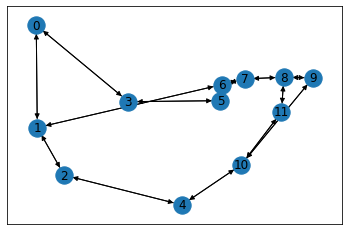

In [17]:
# Define physical network
path = "/content/22SS-CSPTP-based-ILP/dataset/nsfnetbw"
filename = os.path.join(path, "network.gml")
physical_network = nx.read_gml(filename, label="id")
physical_node_size = len(physical_network.nodes())
print("物理ネットワークのノード集合", G.nodes())
print("物理ネットワークのリンク集合", G.edges())

print(r"データ転送の処理遅延$d_{i}^{\mathrm{node}}$", nx.get_node_attributes(G, "delay"))
print(r"伝送遅延$d_{i,j}^{\mathrm{link}}$", nx.get_edge_attributes(G, "delay"))
print(r"処理容量$P_i$", nx.get_node_attributes(G, "capacity"))
print(r"帯域幅$B_{i,j}$", nx.get_edge_attributes(G, "bandwidth"))
pos = {n: (physical_network.nodes()[n]["lng"], physical_network.nodes()[n]["lat"]) for n in physical_network.nodes()}
nx.draw_networkx(physical_network, pos=pos)

In [18]:
# define service chain requirements
filename = os.path.join(path, "service_chain_requirements.json")
with open(filename) as f:
  connections = json.load(f)
for connection in connections:
  connection['required_processing_func'] = {int(k): v for k, v in connection['required_processing_func'].items()}
connection = connections[0]
"""
{'arrival_time': 到着時間（今回は利用しない）, 
'destination': 終点ノード, 
'id': サービスチェイン要求のID, 
'origin': 始点ノード, 
'processing_time': サービスチェイン要求がサービスを利用する時間（今回は利用しない）,
'request': R_cに対応，ネットワーク機能の列,
'required_bandwidth': サービスチェイン要求 𝑐 が要求する固定ビットレート帯域 b_c,
'required_processing_func': {'0': ネットワーク機能0の実行に必要な処理容量, '1': ネットワーク機能1の実行に必要な処理容量, '2': ネットワーク機能2の実行に必要な処理容量, '4': ネットワーク機能4の実行に必要な処理容量, '5': ネットワーク機能5の実行に必要な処理容量},
'required_processing_node':パケット転送に必要な処理容量}
"""
print(connection)

{'arrival_time': 0.5396058372591854, 'destination': 10, 'id': 0, 'origin': 8, 'processing_time': 100.0, 'request': [0, 1, 2, 5, 4], 'required_bandwidth': 4.0, 'required_processing_func': {0: 0.00092, 1: 0.0009, 2: 0.0133, 4: 0.0107, 5: 0.0054}, 'required_processing_node': 0.0005}


## サービスチェイン要求

Service | Sequence of functions 
---|---
Web service | NAT-FW-TM-WOC-IDPS
VoIP | NAT-FW-TM-FW-NAT
Video streaming | NAT-FW-TM-VOC-IDPS
Online gaming | NAT-FW-VOC-WOC-IDPS

## ネットワーク機能
- NAT: Network Address Translator.             
- FW: Firewall                                 
- TM: Traffic Monitoring                       
- IDPS: Intrusion Detection Prevention System
- VOC: Video Optimization Controller 

In [19]:
filename = os.path.join(path, "function_placement.json")
with open(filename) as f:
  function_placement = json.load(f)
placement = function_placement["placement"]
print(placement)
F = set(function_placement['functions'])
print(r"ネットワーク機能の集合$\mathcal{F}$", F)
"""
各数値は以下のネットワーク機能に対応する
便宜上，数値で表現している．
# NAT (1): Network Address Translator
# FW (2): Firewall
# TM (3): Traffic Monitoring
# IDPS (4): Intrusion Detection Prevention System
# VOC (5): Video Optimization Controller
"""

imaginary_links = pd.DataFrame.from_dict(placement)
imaginary_nodes = {f: f+physical_node_size for f in F}
"""
{0: 12, 1: 13, 2: 14, 3: 15, 4: 16, 5: 17}
例えば，{0: 12}はネットワーク機能0(NAT)に対応する架空ノードのIDは12であることを示している．
架空ノードをfunctionのID+物理ノード数として定義することで，架空ノードのIDからfunction IDを計算できる．
"""
print("架空ノード", imaginary_nodes)
"""
    delay  function  physical_node
6      50         3             11
物理ノード11はネットワーク機能3(WOC)に対応する架空ノードのID14と接続しており，その処理遅延は50 [ms]であることを示している．
"""
print("仮想リンクの情報", imaginary_links)


[{'delay': 50, 'function': 0, 'physical_node': 0}, {'delay': 50, 'function': 0, 'physical_node': 2}, {'delay': 50, 'function': 1, 'physical_node': 1}, {'delay': 50, 'function': 1, 'physical_node': 6}, {'delay': 50, 'function': 2, 'physical_node': 4}, {'delay': 50, 'function': 2, 'physical_node': 3}, {'delay': 50, 'function': 3, 'physical_node': 11}, {'delay': 50, 'function': 3, 'physical_node': 5}, {'delay': 50, 'function': 4, 'physical_node': 8}, {'delay': 50, 'function': 4, 'physical_node': 8}, {'delay': 50, 'function': 5, 'physical_node': 7}, {'delay': 50, 'function': 5, 'physical_node': 9}]
ネットワーク機能の集合$\mathcal{F}$ {0, 1, 2, 3, 4, 5}
架空ノード {0: 12, 1: 13, 2: 14, 3: 15, 4: 16, 5: 17}
仮想リンクの情報     delay  function  physical_node
0      50         0              0
1      50         0              2
2      50         1              1
3      50         1              6
4      50         2              4
5      50         2              3
6      50         3             11
7      50       

拡張ネットワークのノード集合 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
拡張ネットワークのリンク集合 [(0, 1), (0, 3), (0, 12), (1, 0), (1, 2), (1, 6), (1, 13), (2, 1), (2, 4), (2, 12), (3, 0), (3, 5), (3, 14), (4, 2), (4, 10), (4, 14), (5, 3), (5, 6), (5, 15), (6, 1), (6, 5), (6, 7), (6, 13), (7, 8), (7, 6), (7, 17), (8, 9), (8, 11), (8, 7), (8, 16), (9, 8), (9, 10), (9, 17), (10, 9), (10, 11), (10, 4), (11, 8), (11, 10), (11, 15), (12, 0), (12, 2), (13, 1), (13, 6), (14, 4), (14, 3), (15, 11), (15, 5), (16, 8), (17, 7), (17, 9)]


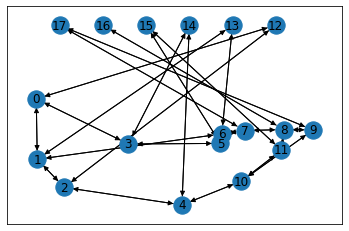

In [20]:
# define augmented network
G = physical_network.copy()
for func, node in imaginary_nodes.items():
  G.add_node(node, lng=-(func+1)*8 - 70, lat=60, delay=0)
imaginary_links.apply(lambda x: G.add_edge(x.physical_node, imaginary_nodes[x.function], delay=0), axis=1)
imaginary_links.apply(lambda x: G.add_edge(imaginary_nodes[x.function], x.physical_node, delay=x.delay * 1e-3), axis=1) # d_{i,j}^{func}
print("拡張ネットワークのノード集合", G.nodes())
print("拡張ネットワークのリンク集合", G.edges())
pos = {n: (G.nodes()[n]["lng"], G.nodes()[n]["lat"]) for n in G.nodes()}
nx.draw_networkx(G, pos=pos)

In [21]:
# define the origin and destination of k-th subpath
a = []
b = []
for c in connections:
  R_c = c['request']
  K_c = len(R_c)
  o_c = c['origin']
  d_c = c['destination']
  a_ck = []
  b_ck = []
  for k in range(K_c+1):
    if k == 0:
      a_ck.append(o_c)
    if k == K_c:
      b_ck.append(d_c)
    else:
      a_ck.append(imaginary_nodes[R_c[k]])
      b_ck.append(imaginary_nodes[R_c[k]])
  a.append(a_ck)
  b.append(b_ck)
print("a_k =", a[0])
print("b_k =", b[0])

a_k = [8, 12, 13, 14, 17, 16]
b_k = [12, 13, 14, 17, 16, 10]


In [22]:
# formualte ILP
m = pulp.LpProblem("SPTP-based-ILP", pulp.LpMinimize)

# define binary decision variables
x = {}
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c+1):
    for i, j in G.edges():
      x[i,j,c,k] = pulp.LpVariable("x_{:},{:},{:},{:}".format(i, j, c, k), 0, 1, pulp.LpBinary)
      # 決定変数にcを入れることで複数のサービスチェイン要求に対応できるようにしています．c>1の場合，これはバッチ処理に相当します．
      # 以降のプログラムではあまり意識しなくても問題ないです．
# define objective function
m += pulp.lpSum(G[i][j]["delay"] * pulp.lpSum(x[i,j,c,k]         for c in range(len(connections)) for k in range(len(connections[c]['request'])+1) ) for i, j in physical_network.edges()) \
      + pulp.lpSum(G.nodes()[v]["delay"] * pulp.lpSum(x[v,j,c,k] for c in range(len(connections)) for k in range(len(connections[c]['request'])+1) ) for v, j in physical_network.edges()) \
      + pulp.lpSum(G[v_f][v]["delay"] * pulp.lpSum(x[v_f,v,c,k]  for c in range(len(connections)) for k in range(len(connections[c]['request'])+1) ) for v_f, v in G.edges() if v_f in imaginary_nodes.values()), "Objective function"



In [ ]:
# define constraint (2)
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c + 1):
    for i in G.nodes():
      if i == a[c][k]:
        m += ここに該当する制約式を埋めてください, f"flow_constraint_c{c}_k{k}_i{i}"
      elif i == b[c][k]:
        m += ここに該当する制約式を埋めてください, f"flow_constraint_c{c}_k{k}_i{i}"
      else:
        m += ここに該当する制約式を埋めてください, f"flow_constraint_c{c}_k{k}_i{i}"

In [ ]:
# define constraint (3)
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c):
    v_f_ck = b[c][k]
    for i in G.neighbors(v_f_ck):
      m += ここに該当する制約式を埋めてください, "connectivity_of_subpath_constraint_i{:}j{:}c{:}k{:}".format(i, v_f_ck, c, k)

In [ ]:
# define constraint (4)
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c+1):
    for i, v_f in G.edges():
      if v_f in imaginary_nodes.values() and not v_f is b[c][k]:
        m += x[i, v_f, c, k] == 0, "infeasible_link_i{:}j{:}k{:}c{:}".format(i, v_f, k, c)


In [ ]:
# define constraint (5)
for i, j in physical_network.edges():
  m += pulp.lpSum(connection['required_bandwidth'] * pulp.lpSum(x[i, j, c, k] for k in range(len(connection['request'])+1)) for c, connection in enumerate(connections)) <= physical_network[i][j]["bandwidth"], "physical_link_capacity_i{:}j{:}".format(i, j)
# define constraint (6)
for v in physical_network.nodes():
  m += pulp.lpSum(connection["required_processing_node"] * pulp.lpSum(x[v,j,c,k] for j in physical_network.neighbors(v) for k in range(len(connection['request'])+1)) + \
      pulp.lpSum(connection["required_processing_func"][v_f-physical_node_size] * pulp.lpSum(x[v_f,v,c,k] for k in range(len(connection['request'])+1)) for v_f in G.neighbors(v) if v_f in imaginary_nodes.values() and v_f-physical_node_size in connection['request']) for c, connection in enumerate(connections)) \
  <= physical_network.nodes()[v]["capacity"], "processing_capacity_constraint_v{:}".format(v)
# define additional constraints
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  o = connection['origin']
  d = connection['destination']
  m += pulp.lpSum(x[i,o,c,0] for i in G.neighbors(o)) == 0, "constraint_7_w{:}".format(c)
  m += pulp.lpSum(x[d,i,c,len(connection['request'])] for i in G.neighbors(d)) == 0, "constraint_8_w{:}".format(c)


In [ ]:
# LP file
m

In [ ]:
start = time.perf_counter()
status = m.solve()
end = time.perf_counter()
elapsed = end - start
print(f"Status: {pulp.LpStatus[status]}, Objective value: {pulp.value(m.objective)}, Execution time: {elapsed}")
for c in range(len(connections)):
  K_c = len(connections[c]['request'])
  for k in range(K_c+1):
    for i, j in G.edges():
      value = pulp.value(x[i,j,c,k])
      if value == 1:
        print(f"{i}\t{j}\t{c}\t{k}\t{value}")

Status: Optimal, Objective value: 121.44999999999996, Execution time: 0.03790297200066561
0	12	0	0	1.0
1	0	0	0	1.0
6	1	0	0	1.0
7	6	0	0	1.0
8	7	0	0	1.0
0	1	0	1	1.0
1	13	0	1	1.0
12	0	0	1	1.0
1	2	0	2	1.0
2	4	0	2	1.0
4	14	0	2	1.0
13	1	0	2	1.0
4	10	0	3	1.0
9	17	0	3	1.0
10	9	0	3	1.0
14	4	0	3	1.0
8	16	0	4	1.0
9	8	0	4	1.0
17	9	0	4	1.0
8	9	0	5	1.0
9	10	0	5	1.0
16	8	0	5	1.0


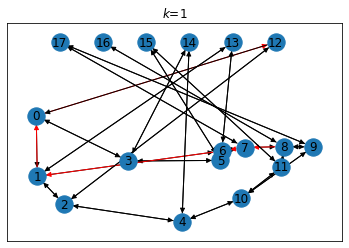

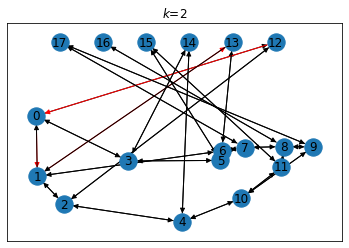

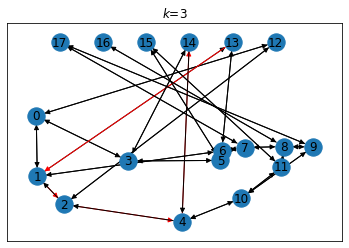

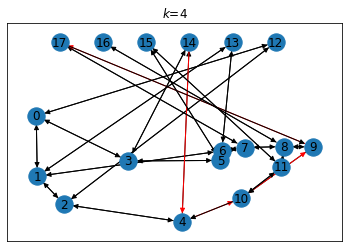

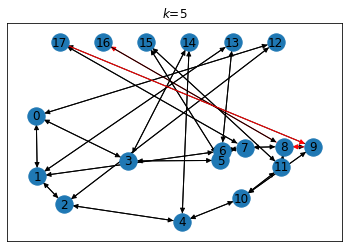

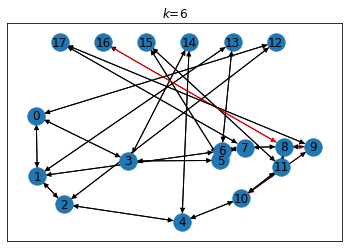

In [ ]:
for c in range(len(connections)):
  K_c = len(connections[c]['request'])
  for k in range(K_c+1):
    for i, j in G.edges():
      G[i][j]["color"] = "k"
    for i, j in G.edges():
      value = pulp.value(x[i,j,c,k])
      if value == 1:
        G[i][j]["color"] = "r"
    colors = list(nx.get_edge_attributes(G, "color").values())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pos = {n: (G.nodes()[n]["lng"], G.nodes()[n]["lat"]) for n in G.nodes()}
    nx.draw_networkx(G, pos=pos, edge_color=colors, ax=ax)
    ax.set_title(f"$k$={k+1}")

他のネットワークやサービスチェイン要求を記述したファイルが`/content/22SS-CSPTP-based-ILP/dataset`以下にあります．
他のネットワークでも同様に結果が得られるか確認してください．
例えば，`/content/22SS-CSPTP-based-ILP/dataset/nrof_nodes100`．